In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa

import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras
import warnings
from keras.utils import Sequence
warnings.filterwarnings("ignore")
SIZE = 299
SEED = 777
THRESHOLD = 0.2

Using TensorFlow backend.


In [2]:
# Load dataset info
DIR = '../input/'
data = pd.read_csv('../input/train.csv')

# train_dataset_info = []
# for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
#     train_dataset_info.append({
#         'path':os.path.join(path_to_train, name),
#         'labels':np.array([int(label) for label in labels])})
# train_dataset_info = np.array(train_dataset_info)

In [3]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)
paths, labels = getTrainDataset()

In [4]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, channels = [], shuffle = False, use_cache = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.channels = channels
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], len(channels)))
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            item = self.augment(item)
            yield item
            
    def __load_image(self, path):
        images = []
        for channel in self.channels:
            images.append(np.array(Image.open(path + '_' + channel + '.png')))

        if len(self.channels) >= 2:
            im = np.stack((
                images
            ), -1)
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)

        else:
            im = images[0]
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)
            im = np.expand_dims(im, 2)
        return im
    def augment(self, image):
        if 0 == 1:
            augment_img = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Flipud(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)


            image_aug = augment_img.augment_image(image)
            return image_aug
        else:
            return image
    

In [5]:
SHAPE = (299, 299, 4)

In [6]:
channels = ["red"]
for path in paths[0:10]:
    images = []
    for channel in channels:
        print(channel)
        images.append(np.array(Image.open(path + '_' + channel + '.png')))

    if len(channels) >= 2:
        im = np.stack((
            images
        ), -1)
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        
    else:
        im = images[0]
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        im = np.expand_dims(im, 2)
    print(im.shape)

red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)


In [7]:

# class data_generator:
    
#     def create_train(dataset_info, batch_size, shape, augument=True):
#         assert shape[2] == 3
#         while True:
#             dataset_info = shuffle(dataset_info)
#             for start in range(0, len(dataset_info), batch_size):
#                 end = min(start + batch_size, len(dataset_info))
#                 batch_images = []
#                 X_train_batch = dataset_info[start:end]
#                 batch_labels = np.zeros((len(X_train_batch), 28))
#                 for i in range(len(X_train_batch)):
#                     image = data_generator.load_image(
#                         X_train_batch[i]['path'], shape)   
#                     if augument:
#                         image = data_generator.augment(image)
#                     batch_images.append(image/255.)
#                     batch_labels[i][X_train_batch[i]['labels']] = 1
#                 yield np.array(batch_images, np.float32), batch_labels

#     def load_image(path, shape):
#         image_red_ch = Image.open(path+'_red.png')
#         image_yellow_ch = Image.open(path+'_yellow.png')
#         image_green_ch = Image.open(path+'_green.png')
#         image_blue_ch = Image.open(path+'_blue.png')
#         image = np.stack((
#         np.array(image_red_ch), 
#         np.array(image_green_ch), 
#         np.array(image_blue_ch)), -1)
#         image = cv2.resize(image, (shape[0], shape[1]))
#         return image

#     def augment(image):
#         augment_img = iaa.Sequential([
#             iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
#                 iaa.Fliplr(0.5),
#                 iaa.Flipud(0.5),
#             ])], random_order=True)

#         image_aug = augment_img.augment_image(image)
#         return image_aug

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D, MaxPooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.utils import multi_gpu_model

In [9]:
def create_model(input_shape, n_out, channels):
    input_tensor = Input(shape=(299,299,len(channels)))

    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=(299,299,3)
                            )
    bn = BatchNormalization()(input_tensor)
    x = Conv2D(3, kernel_size=(1,1), activation='relu', padding = "same")(bn)
    x = base_model(x)
    x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [10]:
def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [11]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 10; batch_size = 32;VAL_RATIO = .1;DEBUG = False
# split data into train, valid
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

if DEBUG == True:  # use only small subset for debugging, Kaggle's RAM is limited
    pathsTrain = paths[0:256]
    labelsTrain = labels[0:256]
    pathsVal = paths[lastTrainIndex:lastTrainIndex+256]
    labelsVal = labels[lastTrainIndex:lastTrainIndex+256]
    use_cache = True
else:
    pathsTrain = paths[0:lastTrainIndex]
    labelsTrain = labels[0:lastTrainIndex]
    pathsVal = paths[lastTrainIndex:]
    labelsVal = labels[lastTrainIndex:]
    use_cache = False

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)
use_cache = True
tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, SHAPE, channels, use_cache=use_cache)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, SHAPE, channels, use_cache=use_cache)

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [12]:
# create train and valid datagens
# train_generator = data_generator.create_train(
#     train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
# validation_generator = data_generator.create_train(
#     train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

In [13]:
checkpoint = ModelCheckpoint('../working/InceptionV3.h5', monitor='val_f1', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_f1', factor=0.5, patience=10, 
                                   verbose=1, mode='max', epsilon=0.0001)
early = EarlyStopping(monitor="val_f1", 
                      mode="max", 
                      patience=20)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [14]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [15]:
# warm up model
import tensorflow as tf
channels = ["green", "blue", "red", "yellow"]
# with tf.device('/cpu:0'):
model = create_model(
    input_shape=(SIZE,SIZE,4), 
    n_out=28, channels = channels)

for layer in model.layers:
    layer.trainable = False
model.layers[1].trainable = True
model.layers[2].trainable = True
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True

model.summary()
# model = multi_gpu_model(model, gpus = 2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 4)       16        
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 299, 299, 3)       15        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 6, 6, 128)         2359424   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
__________

In [16]:
model.compile(
    loss=focal_loss(), 
    optimizer=Adam(1e-04),
    metrics=['acc', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 4)       16        
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 299, 299, 3)       15        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 6, 6, 128)         2359424   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
__________

In [17]:

tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, SHAPE, channels, use_cache=use_cache)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, SHAPE, channels, use_cache=use_cache)

In [18]:
hist =  model.fit_generator(
        tg,
        steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))/2,
        validation_data=vg,
        validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))/2,
        epochs=20, 
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/4
437/437 [==============================] - 396s 905ms/step - loss: 22.4756 - acc: 0.2201 - f1: 0.0893 - val_loss: 17.1416 - val_acc: 0.2953 - val_f1: 0.0784
Epoch 2/4
437/437 [==============================] - 422s 965ms/step - loss: 17.4489 - acc: 0.2937 - f1: 0.0947 - val_loss: 17.3176 - val_acc: 0.1983 - val_f1: 0.0809
Epoch 3/4
437/437 [==============================] - 133s 304ms/step - loss: 16.4641 - acc: 0.3214 - f1: 0.0999 - val_loss: 17.1856 - val_acc: 0.2608 - val_f1: 0.0742
Epoch 4/4
437/437 [==============================] - 152s 347ms/step - loss: 16.0222 - acc: 0.3309 - f1: 0.1021 - val_loss: 16.8626 - val_acc: 0.2353 - val_f1: 0.0901


In [19]:
# train all layers

for layer in model.layers:
    print(layer)
    layer.trainable = True
model.compile(loss=focal_loss(),
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])

In [20]:

batch_size = 12
hist =  model.fit_generator(
        tg,
        steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))/2,
        validation_data=vg,
        validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))/2,
        epochs=200, 
        verbose=1,
        callbacks=callbacks_list)
    

Epoch 1/200
1166/1165 [==============================] - 621s 532ms/step - loss: 14.4375 - acc: 0.3906 - f1: 0.1197 - val_loss: 13.4623 - val_acc: 0.4032 - val_f1: 0.1400

Epoch 00001: val_f1 improved from -inf to 0.14002, saving model to ../working/InceptionV3.h5
Epoch 2/200
1166/1165 [==============================] - 561s 481ms/step - loss: 12.7332 - acc: 0.4688 - f1: 0.1554 - val_loss: 12.9921 - val_acc: 0.4407 - val_f1: 0.1609

Epoch 00002: val_f1 improved from 0.14002 to 0.16094, saving model to ../working/InceptionV3.h5
Epoch 3/200
1166/1165 [==============================] - 583s 500ms/step - loss: 11.5189 - acc: 0.5200 - f1: 0.1855 - val_loss: 12.5422 - val_acc: 0.4855 - val_f1: 0.1883

Epoch 00003: val_f1 improved from 0.16094 to 0.18827, saving model to ../working/InceptionV3.h5
Epoch 4/200
1166/1165 [==============================] - 539s 463ms/step - loss: 9.7294 - acc: 0.5954 - f1: 0.2320 - val_loss: 15.1233 - val_acc: 0.4477 - val_f1: 0.1800

Epoch 00004: val_f1 did not 

1166/1165 [==============================] - 872s 748ms/step - loss: 0.3034 - acc: 0.7205 - f1: 0.5514 - val_loss: 32.1464 - val_acc: 0.5058 - val_f1: 0.2478

Epoch 00036: val_f1 did not improve from 0.24980
Epoch 37/200
1166/1165 [==============================] - 570s 489ms/step - loss: 0.2808 - acc: 0.7381 - f1: 0.5504 - val_loss: 35.0316 - val_acc: 0.5332 - val_f1: 0.2354

Epoch 00037: val_f1 did not improve from 0.24980
Epoch 38/200
1166/1165 [==============================] - 540s 463ms/step - loss: 0.2937 - acc: 0.7282 - f1: 0.5500 - val_loss: 32.6343 - val_acc: 0.5409 - val_f1: 0.2446

Epoch 00038: val_f1 did not improve from 0.24980
Epoch 39/200
1166/1165 [==============================] - 582s 499ms/step - loss: 0.2799 - acc: 0.7288 - f1: 0.5521 - val_loss: 32.2615 - val_acc: 0.5133 - val_f1: 0.2488

Epoch 00039: val_f1 did not improve from 0.24980
Epoch 40/200
1166/1165 [==============================] - 551s 472ms/step - loss: 0.2520 - acc: 0.7223 - f1: 0.5536 - val_loss: 3

In [53]:
# model.compile(loss=f1_loss,
#             optimizer=Adam(lr=1e-4),
#             metrics=['accuracy', f1])
# hist =  model.fit_generator(
#         tg,
#         steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))/2,
#         validation_data=vg,
#         validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))/2,
#         epochs=200, 
#         verbose=1,
#         callbacks=callbacks_list)

Epoch 1/200


 150/1165 [==>...........................] - ETA: 17:53:14 - loss: 0.6426 - acc: 0.6875 - f1: 0.43 - ETA: 9:00:15 - loss: 0.5811 - acc: 0.7500 - f1: 0.4983 - ETA: 6:02:41 - loss: 0.5659 - acc: 0.7292 - f1: 0.505 - ETA: 4:33:54 - loss: 0.5507 - acc: 0.7031 - f1: 0.521 - ETA: 3:40:30 - loss: 0.5315 - acc: 0.7000 - f1: 0.535 - ETA: 3:04:57 - loss: 0.5220 - acc: 0.7396 - f1: 0.540 - ETA: 2:39:32 - loss: 0.5160 - acc: 0.7366 - f1: 0.545 - ETA: 2:20:29 - loss: 0.5109 - acc: 0.7500 - f1: 0.547 - ETA: 2:05:40 - loss: 0.5013 - acc: 0.7361 - f1: 0.554 - ETA: 1:53:47 - loss: 0.5037 - acc: 0.7281 - f1: 0.548 - ETA: 1:44:05 - loss: 0.5025 - acc: 0.7330 - f1: 0.547 - ETA: 1:36:00 - loss: 0.5076 - acc: 0.7448 - f1: 0.540 - ETA: 1:29:09 - loss: 0.5126 - acc: 0.7452 - f1: 0.535 - ETA: 1:23:16 - loss: 0.5132 - acc: 0.7478 - f1: 0.534 - ETA: 1:18:11 - loss: 0.5088 - acc: 0.7479 - f1: 0.537 - ETA: 1:13:43 - loss: 0.5102 - acc: 0.7480 - f1: 0.534 - ETA: 1:09:46 - loss: 0.5129 - acc: 0.7574 - f1: 0.530 - ET

 304/1165 [======>.......................] - ETA: 13:05 - loss: 0.4639 - acc: 0.7293 - f1: 0.548 - ETA: 13:02 - loss: 0.4651 - acc: 0.7296 - f1: 0.547 - ETA: 12:59 - loss: 0.4656 - acc: 0.7304 - f1: 0.546 - ETA: 12:55 - loss: 0.4652 - acc: 0.7303 - f1: 0.547 - ETA: 12:52 - loss: 0.4658 - acc: 0.7296 - f1: 0.546 - ETA: 12:49 - loss: 0.4663 - acc: 0.7306 - f1: 0.545 - ETA: 12:46 - loss: 0.4659 - acc: 0.7303 - f1: 0.546 - ETA: 12:43 - loss: 0.4658 - acc: 0.7298 - f1: 0.546 - ETA: 12:40 - loss: 0.4657 - acc: 0.7300 - f1: 0.546 - ETA: 12:37 - loss: 0.4658 - acc: 0.7301 - f1: 0.546 - ETA: 12:34 - loss: 0.4650 - acc: 0.7292 - f1: 0.547 - ETA: 12:32 - loss: 0.4652 - acc: 0.7297 - f1: 0.546 - ETA: 12:29 - loss: 0.4650 - acc: 0.7297 - f1: 0.546 - ETA: 12:26 - loss: 0.4655 - acc: 0.7294 - f1: 0.546 - ETA: 12:23 - loss: 0.4657 - acc: 0.7293 - f1: 0.546 - ETA: 12:20 - loss: 0.4657 - acc: 0.7298 - f1: 0.546 - ETA: 12:17 - loss: 0.4656 - acc: 0.7292 - f1: 0.546 - ETA: 12:15 - loss: 0.4660 - acc: 0.72

 461/1165 [==========>...................] - ETA: 8:29 - loss: 0.4701 - acc: 0.7300 - f1: 0.53 - ETA: 8:28 - loss: 0.4699 - acc: 0.7297 - f1: 0.53 - ETA: 8:27 - loss: 0.4697 - acc: 0.7295 - f1: 0.53 - ETA: 8:26 - loss: 0.4695 - acc: 0.7296 - f1: 0.53 - ETA: 8:25 - loss: 0.4696 - acc: 0.7296 - f1: 0.53 - ETA: 8:24 - loss: 0.4698 - acc: 0.7292 - f1: 0.53 - ETA: 8:22 - loss: 0.4699 - acc: 0.7288 - f1: 0.53 - ETA: 8:21 - loss: 0.4697 - acc: 0.7290 - f1: 0.53 - ETA: 8:20 - loss: 0.4699 - acc: 0.7290 - f1: 0.53 - ETA: 8:19 - loss: 0.4698 - acc: 0.7292 - f1: 0.53 - ETA: 8:18 - loss: 0.4697 - acc: 0.7292 - f1: 0.53 - ETA: 8:17 - loss: 0.4696 - acc: 0.7287 - f1: 0.53 - ETA: 8:16 - loss: 0.4698 - acc: 0.7288 - f1: 0.53 - ETA: 8:15 - loss: 0.4698 - acc: 0.7288 - f1: 0.53 - ETA: 8:14 - loss: 0.4697 - acc: 0.7291 - f1: 0.53 - ETA: 8:13 - loss: 0.4701 - acc: 0.7287 - f1: 0.53 - ETA: 8:12 - loss: 0.4701 - acc: 0.7280 - f1: 0.53 - ETA: 8:11 - loss: 0.4703 - acc: 0.7278 - f1: 0.53 - ETA: 8:10 - loss: 0

 618/1165 [==============>...............] - ETA: 6:16 - loss: 0.4697 - acc: 0.7313 - f1: 0.53 - ETA: 6:16 - loss: 0.4697 - acc: 0.7312 - f1: 0.53 - ETA: 6:15 - loss: 0.4699 - acc: 0.7310 - f1: 0.53 - ETA: 6:14 - loss: 0.4698 - acc: 0.7310 - f1: 0.53 - ETA: 6:14 - loss: 0.4698 - acc: 0.7309 - f1: 0.53 - ETA: 6:13 - loss: 0.4699 - acc: 0.7310 - f1: 0.53 - ETA: 6:12 - loss: 0.4698 - acc: 0.7309 - f1: 0.53 - ETA: 6:12 - loss: 0.4700 - acc: 0.7309 - f1: 0.53 - ETA: 6:11 - loss: 0.4700 - acc: 0.7310 - f1: 0.53 - ETA: 6:10 - loss: 0.4702 - acc: 0.7310 - f1: 0.53 - ETA: 6:10 - loss: 0.4700 - acc: 0.7310 - f1: 0.53 - ETA: 6:09 - loss: 0.4699 - acc: 0.7314 - f1: 0.53 - ETA: 6:08 - loss: 0.4699 - acc: 0.7313 - f1: 0.53 - ETA: 6:08 - loss: 0.4700 - acc: 0.7315 - f1: 0.53 - ETA: 6:07 - loss: 0.4699 - acc: 0.7317 - f1: 0.53 - ETA: 6:07 - loss: 0.4699 - acc: 0.7316 - f1: 0.53 - ETA: 6:06 - loss: 0.4699 - acc: 0.7316 - f1: 0.53 - ETA: 6:05 - loss: 0.4698 - acc: 0.7317 - f1: 0.53 - ETA: 6:05 - loss: 0

 775/1165 [==================>...........] - ETA: 4:41 - loss: 0.4717 - acc: 0.7374 - f1: 0.53 - ETA: 4:40 - loss: 0.4717 - acc: 0.7376 - f1: 0.53 - ETA: 4:39 - loss: 0.4718 - acc: 0.7377 - f1: 0.53 - ETA: 4:39 - loss: 0.4719 - acc: 0.7376 - f1: 0.53 - ETA: 4:38 - loss: 0.4719 - acc: 0.7378 - f1: 0.53 - ETA: 4:38 - loss: 0.4719 - acc: 0.7380 - f1: 0.53 - ETA: 4:37 - loss: 0.4719 - acc: 0.7379 - f1: 0.53 - ETA: 4:37 - loss: 0.4718 - acc: 0.7379 - f1: 0.53 - ETA: 4:36 - loss: 0.4718 - acc: 0.7380 - f1: 0.53 - ETA: 4:35 - loss: 0.4718 - acc: 0.7381 - f1: 0.53 - ETA: 4:35 - loss: 0.4719 - acc: 0.7382 - f1: 0.53 - ETA: 4:34 - loss: 0.4717 - acc: 0.7382 - f1: 0.53 - ETA: 4:34 - loss: 0.4718 - acc: 0.7384 - f1: 0.53 - ETA: 4:33 - loss: 0.4718 - acc: 0.7381 - f1: 0.53 - ETA: 4:33 - loss: 0.4719 - acc: 0.7380 - f1: 0.53 - ETA: 4:32 - loss: 0.4717 - acc: 0.7381 - f1: 0.53 - ETA: 4:32 - loss: 0.4718 - acc: 0.7380 - f1: 0.53 - ETA: 4:31 - loss: 0.4719 - acc: 0.7381 - f1: 0.53 - ETA: 4:30 - loss: 0

 932/1165 [======================>.......] - ETA: 3:20 - loss: 0.4743 - acc: 0.7390 - f1: 0.53 - ETA: 3:20 - loss: 0.4741 - acc: 0.7391 - f1: 0.53 - ETA: 3:19 - loss: 0.4741 - acc: 0.7393 - f1: 0.53 - ETA: 3:19 - loss: 0.4741 - acc: 0.7394 - f1: 0.53 - ETA: 3:18 - loss: 0.4740 - acc: 0.7393 - f1: 0.53 - ETA: 3:18 - loss: 0.4741 - acc: 0.7394 - f1: 0.53 - ETA: 3:18 - loss: 0.4740 - acc: 0.7393 - f1: 0.53 - ETA: 3:18 - loss: 0.4740 - acc: 0.7393 - f1: 0.53 - ETA: 3:17 - loss: 0.4740 - acc: 0.7391 - f1: 0.53 - ETA: 3:17 - loss: 0.4739 - acc: 0.7390 - f1: 0.53 - ETA: 3:16 - loss: 0.4740 - acc: 0.7391 - f1: 0.53 - ETA: 3:15 - loss: 0.4741 - acc: 0.7392 - f1: 0.53 - ETA: 3:15 - loss: 0.4741 - acc: 0.7394 - f1: 0.53 - ETA: 3:14 - loss: 0.4740 - acc: 0.7394 - f1: 0.53 - ETA: 3:14 - loss: 0.4739 - acc: 0.7393 - f1: 0.53 - ETA: 3:13 - loss: 0.4739 - acc: 0.7392 - f1: 0.53 - ETA: 3:13 - loss: 0.4740 - acc: 0.7391 - f1: 0.53 - ETA: 3:13 - loss: 0.4742 - acc: 0.7393 - f1: 0.53 - ETA: 3:12 - loss: 0

1089/1165 [===========================>..] - ETA: 2:07 - loss: 0.4752 - acc: 0.7411 - f1: 0.52 - ETA: 2:06 - loss: 0.4752 - acc: 0.7411 - f1: 0.52 - ETA: 2:06 - loss: 0.4753 - acc: 0.7412 - f1: 0.52 - ETA: 2:05 - loss: 0.4752 - acc: 0.7412 - f1: 0.52 - ETA: 2:04 - loss: 0.4751 - acc: 0.7413 - f1: 0.52 - ETA: 2:04 - loss: 0.4752 - acc: 0.7412 - f1: 0.52 - ETA: 2:03 - loss: 0.4751 - acc: 0.7412 - f1: 0.52 - ETA: 2:03 - loss: 0.4751 - acc: 0.7411 - f1: 0.52 - ETA: 2:02 - loss: 0.4751 - acc: 0.7412 - f1: 0.52 - ETA: 2:02 - loss: 0.4751 - acc: 0.7412 - f1: 0.52 - ETA: 2:01 - loss: 0.4750 - acc: 0.7411 - f1: 0.52 - ETA: 2:00 - loss: 0.4751 - acc: 0.7412 - f1: 0.52 - ETA: 2:00 - loss: 0.4751 - acc: 0.7409 - f1: 0.52 - ETA: 1:59 - loss: 0.4751 - acc: 0.7409 - f1: 0.52 - ETA: 1:59 - loss: 0.4751 - acc: 0.7410 - f1: 0.52 - ETA: 1:58 - loss: 0.4752 - acc: 0.7409 - f1: 0.52 - ETA: 1:57 - loss: 0.4752 - acc: 0.7409 - f1: 0.52 - ETA: 1:57 - loss: 0.4751 - acc: 0.7409 - f1: 0.52 - ETA: 1:56 - loss: 0

1166/1165 [==============================] - ETA: 39s - loss: 0.4749 - acc: 0.7456 - f1: 0.529 - ETA: 39s - loss: 0.4749 - acc: 0.7455 - f1: 0.529 - ETA: 38s - loss: 0.4748 - acc: 0.7455 - f1: 0.529 - ETA: 38s - loss: 0.4748 - acc: 0.7456 - f1: 0.529 - ETA: 37s - loss: 0.4749 - acc: 0.7457 - f1: 0.529 - ETA: 37s - loss: 0.4749 - acc: 0.7458 - f1: 0.529 - ETA: 36s - loss: 0.4750 - acc: 0.7459 - f1: 0.529 - ETA: 36s - loss: 0.4750 - acc: 0.7459 - f1: 0.529 - ETA: 35s - loss: 0.4750 - acc: 0.7459 - f1: 0.529 - ETA: 35s - loss: 0.4750 - acc: 0.7460 - f1: 0.529 - ETA: 34s - loss: 0.4749 - acc: 0.7460 - f1: 0.529 - ETA: 34s - loss: 0.4749 - acc: 0.7461 - f1: 0.529 - ETA: 33s - loss: 0.4749 - acc: 0.7461 - f1: 0.529 - ETA: 32s - loss: 0.4749 - acc: 0.7462 - f1: 0.529 - ETA: 32s - loss: 0.4749 - acc: 0.7462 - f1: 0.529 - ETA: 31s - loss: 0.4748 - acc: 0.7462 - f1: 0.529 - ETA: 31s - loss: 0.4748 - acc: 0.7461 - f1: 0.529 - ETA: 30s - loss: 0.4748 - acc: 0.7461 - f1: 0.529 - ETA: 30s - loss: 0.

KeyboardInterrupt: 

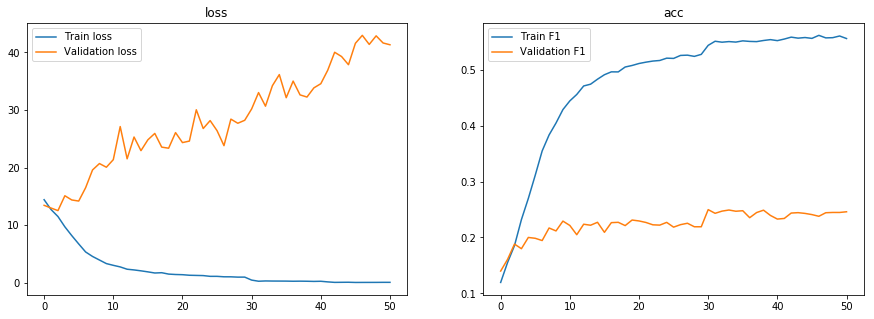

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [42]:
from keras.models import load_model
bestModel = load_model('../working/InceptionV3.h5', custom_objects={'f1': f1, 'f1_loss': f1_loss, 'focal_loss_fixed':focal_loss()})

In [44]:
from tqdm import tqdm
lastFullValPred = np.empty((0, 28))
lastFullValLabels = np.empty((0, 28))
for i in tqdm(range(len(vg))): 
    im, lbl = vg[i]
    scores = bestModel.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:45<00:00,  2.15it/s]


(3108, 28) (3108, 28)


In [45]:
from sklearn.metrics import f1_score as off1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.04it/s]


Individual F1-scores for each class:
[0.81699847 0.61607143 0.71175523 0.65724382 0.71022727 0.5735568
 0.41269841 0.63740458 0.21052632 0.10526316 0.11111111 0.61971831
 0.60869565 0.51851852 0.75897436 0.05405405 0.1686747  0.22222222
 0.40268456 0.38255034 0.26086957 0.65282584 0.55       0.70187394
 0.51162791 0.66382979 0.18947368 0.        ]
Macro F1-score CV = 0.45819464369166657
Probability threshold maximizing CV F1-score for each class:
[0.446 0.565 0.369 0.446 0.454 0.197 0.285 0.437 0.263 0.134 0.076 0.44
 0.572 0.394 0.485 0.096 0.392 0.439 0.524 0.25  0.333 0.242 0.373 0.384
 0.456 0.391 0.201 0.   ]


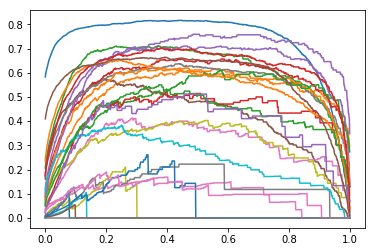

In [46]:
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

In [49]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, batch_size, SHAPE, channels)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*batch_size:i*batch_size+score.shape[0]] = score

100%|████████████████████████████████████████████████████████████████████████████████| 976/976 [07:57<00:00,  2.05it/s]


In [50]:
PP = np.array(P)

In [51]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('transfer_1x1conv_aug_focal_loss.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████| 11702/11702 [00:00<00:00, 51920.22it/s]


In [ ]:
# from tqdm import tqdm
# pathsTest, labelsTest = getTestDataset()

# testg = ProteinDataGenerator(pathsTest, labelsTest, batch_size, SHAPE)
# submit = pd.read_csv(DIR + '/sample_submission.csv')
# P = np.zeros((pathsTest.shape[0], 28))
# for i in tqdm(range(len(testg))):
#     images, labels = testg[i]
#     score = bestModel.predict(images)
#     P[i*batch_size:i*batch_size+score.shape[0]] = score

In [ ]:
# PP = np.array(P)

In [ ]:
# prediction = []

# for row in tqdm(range(submit.shape[0])):
    
#     str_label = ''
    
#     for col in range(PP.shape[1]):
#         if(PP[row, col] < .2):   # to account for losing TP is more costly than decreasing FP
#             #print(PP[row])
#             str_label += ''
#         else:
#             str_label += str(col) + ' '
#     prediction.append(str_label.strip())
    
# submit['Predicted'] = np.array(prediction)
# submit.to_csv('datagenerator_model_v2.csv', index=False)